In [1]:
from collections import namedtuple

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

import os
import tqdm
import json
import sklearn.metrics as sm

# import tensorboardX as tb
# import tensorflow as tf
# import datetime, os

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(31337)

## Create Triplets (first track, subsequent track, time)

from google.colab import drive
drive.mount('/content/drive')

In [2]:
DATA_DIR = "../log/"

In [3]:
data = []

for item in os.listdir(DATA_DIR):
    data.append(pd.read_json(DATA_DIR + item, lines=True))

data = pd.concat(data)

In [4]:
Pair = namedtuple("Session", ["user", "start", "track", "time"])

def get_pairs(user_data):
    pairs = []
    first = None
    prev = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if first is None:
            first = row["track"]
            prev = row["track"]
        else:
            pairs.append(Pair(row["user"], first, row["track"], row["time"]))
            prev = row["track"]

        if row["message"] == "last":
            first = None
            prev = None
    return pairs

In [5]:
pairs = pd.DataFrame(
    data
    .groupby("user")
    .apply(get_pairs)
    .explode()
    .values
    .tolist(),
    columns=["user", "start", "track", "time"]
)

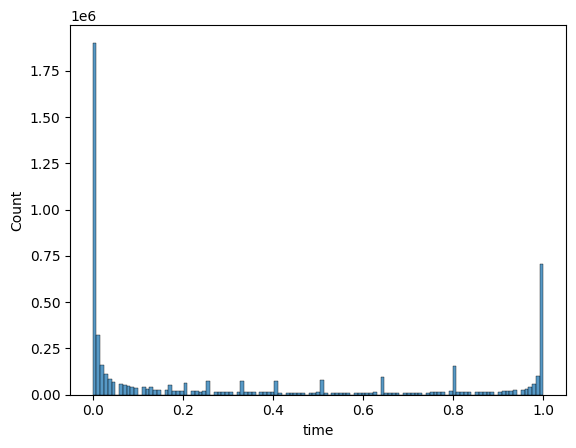

In [6]:
figure, ax = plt.subplots()
sns.histplot(pairs["time"], ax=ax)
pass

In [7]:
pairs.head()

,user,start,track,time
0,0,940,42624,0.0
1,0,940,18157,0.0
2,0,940,39164,0.0
3,0,940,18360,0.0
4,0,940,35707,0.0


## Train Model

In [8]:
rdm = np.random.random(len(pairs))
train_data = pairs[rdm < 0.8]
val_data = pairs[(rdm >= 0.8) & (rdm < 0.9)]
test_data = pairs[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

(4540348, 566772, 567556)

In [37]:
class ContextualRankerHW(pl.LightningModule):
    def __init__(self, embedding_dim=128):
        super().__init__()
        self.embedding_dim = embedding_dim
        
        # We won't have embeddings for everything, but that's ok
        self.context = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)
        self.track = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)
        self.user = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim) # добавил эмбеддинг для юзера
        
        self.song_linear1 = nn.Linear(self.embedding_dim, self.embedding_dim//2)
        self.song_linear2 = nn.Linear(self.embedding_dim//2, 1)
        self.user_linear1 = nn.Linear(self.embedding_dim, self.embedding_dim//2)
        self.user_linear2 = nn.Linear(self.embedding_dim//2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        context = self.context(x[:, 0]) # start track
        track = self.track(x[:, 1]) # next track
        user = self.user(x[:,2])
        
        track_cont_suit = self.song_linear2(self.song_linear1(context * track))
        track_user_suit = self.song_linear2(self.user_linear1(user * track))
        
        return self.sigmoid(track_cont_suit + track_user_suit).squeeze(1)
            
    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = torch.sqrt(F.mse_loss(predictions, y.float(), reduction='mean'))
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def test_step(self, batch, batch_idx, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        targets = y[:, 0].float()
        avgs = y[:, 1].float()
        rdms = y[:, 2].float()

        loss = torch.sqrt(F.mse_loss(predictions, targets, reduction='mean'))
        avg_loss = torch.sqrt(F.mse_loss(avgs, targets, reduction='mean'))
        rdm_loss = torch.sqrt(F.mse_loss(rdms, targets, reduction='mean'))

        self.log("test_loss", loss, prog_bar=prog_bar)
        self.log("avg_loss", avg_loss, prog_bar=prog_bar)
        self.log("rdm_loss", rdm_loss, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True, factor=0.5)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]


In [38]:
class ContextualRankerData(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, features):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.features = features

    def prepare_data(self):
        self.test_data = self.test_data.assign(rdm = np.random.random(len(self.test_data))).assign(avg = self.train_data["time"].mean())

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = td.TensorDataset(
                torch.from_numpy(self.train_data[self.features].values), 
                torch.from_numpy(self.train_data["time"].values)
                )

            self.val_dataset = td.TensorDataset(
                torch.from_numpy(self.val_data[self.features].values), 
                torch.from_numpy(self.val_data["time"].values)
                )

        if stage == "test" or stage is None:  
            self.test_dataset = td.TensorDataset(
                torch.from_numpy(self.test_data[self.features].values),
                torch.from_numpy(self.test_data[["time", "avg", "rdm"]].values)
            )
    def train_dataloader(self):
        return td.DataLoader(self.train_dataset, batch_size=2048*12, shuffle=True, num_workers=8)

    def val_dataloader(self):
        return td.DataLoader(self.val_dataset, batch_size=2048*12, num_workers=8)

    def test_dataloader(self):
        return td.DataLoader(self.test_dataset, batch_size=2048*12, shuffle=False, num_workers=8)

In [39]:
data_module = ContextualRankerData(train_data, val_data, test_data, features = ["start", "track", 'user'])
data_module.setup(stage = "fit")
model = ContextualRankerHW()

for x,y in data_module.train_dataloader():
  out = model(x)
  break

In [40]:
net = ContextualRankerHW()
data_module = ContextualRankerData(train_data, val_data, test_data, features = ["start", "track", 'user'])

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=300,
    accelerator='gpu', 
    devices=1,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=8),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs --host localhost

In [41]:
trainer.fit(
    net, 
    data_module
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type      | Params
-------------------------------------------
0 | context      | Embedding | 6.4 M 
1 | track        | Embedding | 6.4 M 
2 | user         | Embedding | 6.4 M 
3 | song_linear1 | Linear    | 8.3 K 
4 | song_linear2 | Linear    | 65    
5 | user_linear1 | Linear    | 8.3 K 
6 | user_linear2 | Linear    | 65    
7 | sigmoid      | Sigmoid   | 0     
-------------------------------------------
19.2 M    Trainable params
0         Non-trainable params
19.2 M    Total params
76.867    Total estimated model params size (MB)


Epoch 11:   9%|▉         | 17/185 [00:03<00:30,  5.54it/s, v_num=22, val_loss=0.280] 

/home/nullkatar/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [42]:
best = ContextualRankerHW.load_from_checkpoint(checkpoint_callback.best_model_path)

In [43]:
trainer.test(best, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 24/24 [00:00<00:00, 24.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        avg_loss            0.39546605944633484
        rdm_loss            0.5174717903137207
        test_loss           0.27989843487739563
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.27989843487739563,
  'avg_loss': 0.39546605944633484,
  'rdm_loss': 0.5174717903137207}]

In [44]:
np.save('context_embeddings', dict(best.named_parameters())["context.weight"].data.cpu().numpy())
np.save('track_embeddings', dict(best.named_parameters())["track.weight"].data.cpu().numpy())
np.save('user_embeddings', dict(best.named_parameters())["user.weight"].data.cpu().numpy())